Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# Load the data
data = pd.read_csv('insurance.csv')

# Show the first few rows of the data
data.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Data Preprocessing

In [2]:
# Define categorical and numerical columns
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Split the Data

In [3]:
# Split the data
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Plotting the Graphs

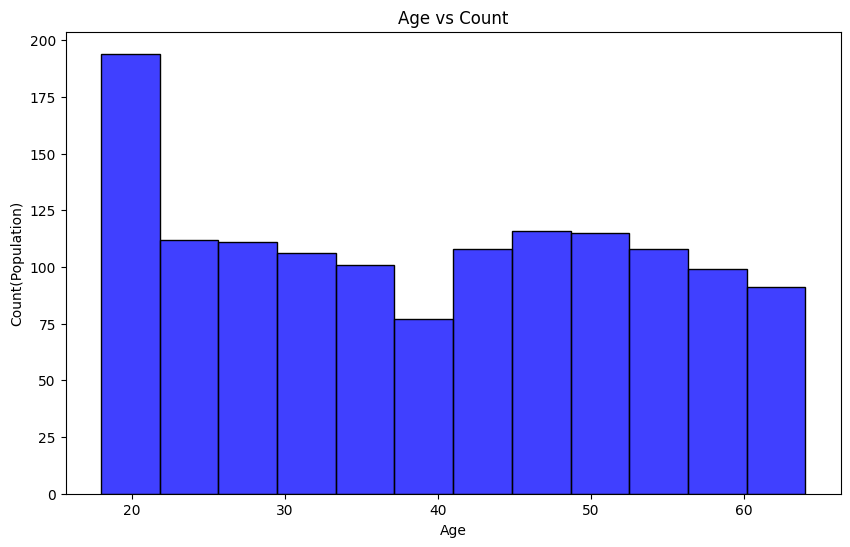

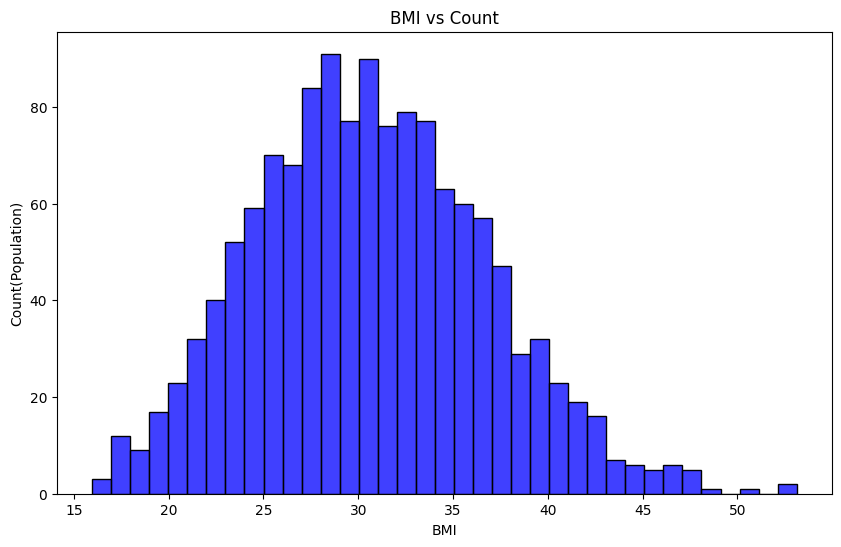

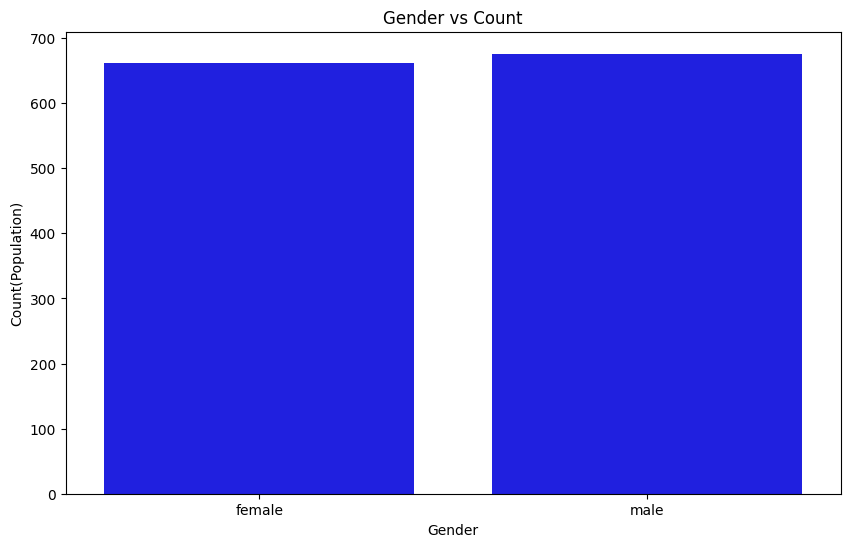

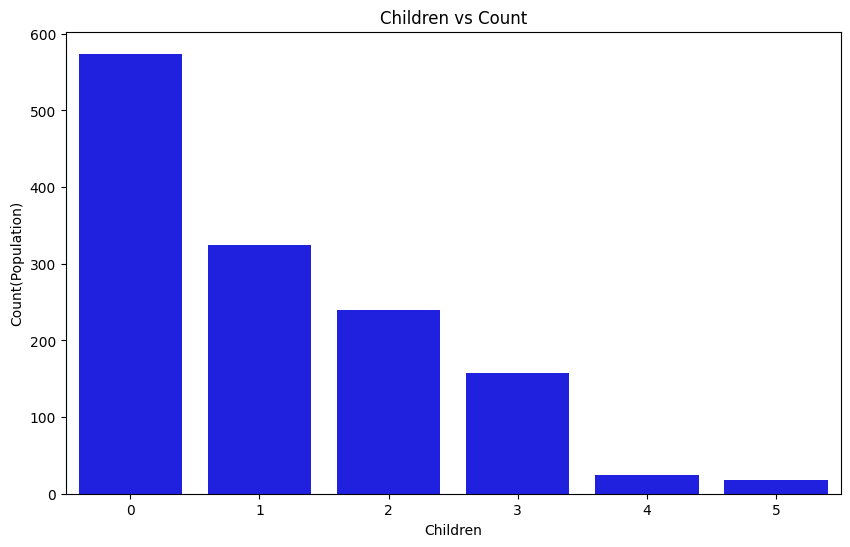

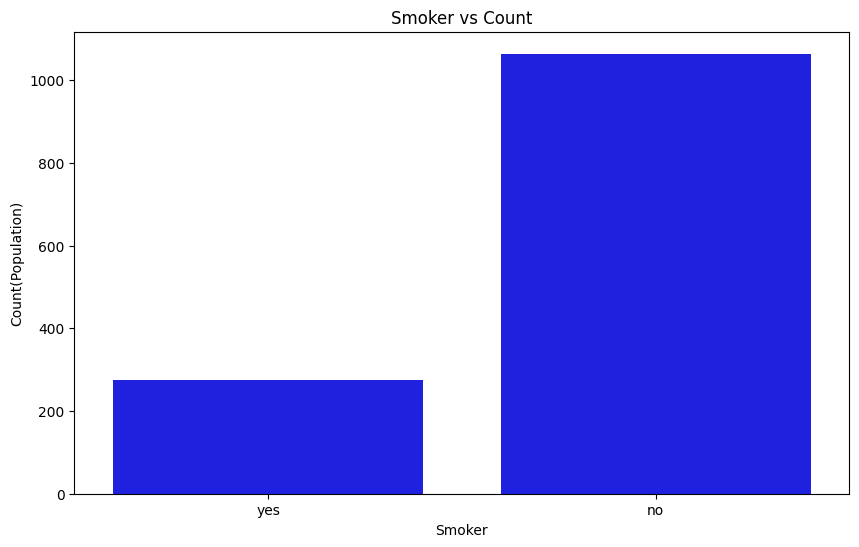

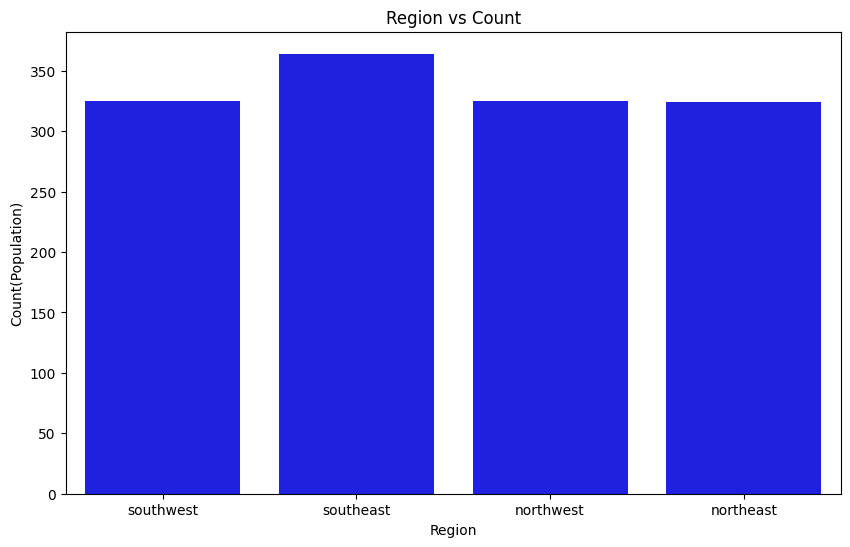

In [4]:
# Age vs. Count
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='age', color='blue', binwidth=4)
plt.title('Age vs Count')
plt.xlabel('Age')
plt.ylabel('Count(Population)')
plt.show()

# BMI vs. Count
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='bmi', color='blue', binwidth=1)
plt.title('BMI vs Count')
plt.xlabel('BMI')
plt.ylabel('Count(Population)')
plt.show()

# Gender vs. Count
plt.figure(figsize=(10, 6))
sns.countplot(x='sex', data=data, color='blue')
plt.title('Gender vs Count')
plt.xlabel('Gender')
plt.ylabel('Count(Population)')
plt.show()

# Children vs. Count
plt.figure(figsize=(10, 6))
sns.countplot(x='children', data=data, color='blue')
plt.title('Children vs Count')
plt.xlabel('Children')
plt.ylabel('Count(Population)')
plt.show()

# Smoker vs. Count
plt.figure(figsize=(10, 6))
sns.countplot(x='smoker', data=data, color='blue')
plt.title('Smoker vs Count')
plt.xlabel('Smoker')
plt.ylabel('Count(Population)')
plt.show()

# Region vs. Count
plt.figure(figsize=(10, 6))
sns.countplot(x='region', data=data, color='blue')
plt.title('Region vs Count')
plt.xlabel('Region')
plt.ylabel('Count(Population)')
plt.show()

Model Training and Hyperparameter Tuning

In [5]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

# Hyperparameter tuning
parameters = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Train a Model and Evaluate
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'R2 Score (Train): {r2_train:.3f}')
print(f'R2 Score (Test): {r2_test:.3f}')
print(f'Mean Squared Error (Test): {mse_test:.3f}')


Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 500}
R2 Score (Train): 0.910
R2 Score (Test): 0.878
Mean Squared Error (Test): 19002944.443


Save the Model

In [6]:
# Save the Model
Pkl_Filename = "insurance_model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)


Load the Model

In [7]:
# Load the Model
with open(Pkl_Filename, 'rb') as file:  
    loaded_model = pickle.load(file)


Prediction

In [8]:
# Ensure the columns are correct and aligned
print(f'X_train columns: {list(X_train.columns)}')

# Predict with the Model
sample = pd.DataFrame([[30, 'female', 25.3, 1, 'no', 'southeast']], 
                      columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region'])

# Align columns to match the training data
X_train_columns = list(loaded_model.named_steps['preprocessor'].transformers_[0][2]) + list(loaded_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['sex', 'smoker', 'region']))

# Transform sample data using the same preprocessor
sample_data_transformed = loaded_model.named_steps['preprocessor'].transform(sample)
sample_data_transformed = pd.DataFrame(sample_data_transformed, columns=X_train_columns)
print("Transformed DataFrame:\n", sample_data_transformed)

# Predict
try:
    predicted_charge = loaded_model.named_steps['regressor'].predict(sample_data_transformed)[0]
    print(f'Predicted Charge: {predicted_charge:.2f}')
except ValueError as e:
    print(f'Error during prediction: {e}')


X_train columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Transformed DataFrame:
         age       bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
0 -0.665156 -0.870846 -0.088428         1.0       0.0        1.0         0.0   

   region_northeast  region_northwest  region_southeast  region_southwest  
0               0.0               0.0               1.0               0.0  
Predicted Charge: 5249.89


C:\Users\gouth\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Train and Save the Model

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import pickle

# Load the data
data = pd.read_csv('insurance.csv')

# Define categorical and numerical columns
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = RandomForestRegressor(random_state=42)

# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Split the data
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Save the model to a file
Pkl_Filename = "insurance_model.pkl"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Load the model to verify
with open('insurance_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Ensure it is working
sample = pd.DataFrame([[30, 'female', 25.3, 1, 'no', 'southeast']], 
                      columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region'])

# Use the model's preprocessor to transform the sample data
X_train_columns = list(loaded_model.named_steps['preprocessor'].transformers_[0][2]) + list(loaded_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['sex', 'smoker', 'region']))
sample_data_transformed = loaded_model.named_steps['preprocessor'].transform(sample)
sample_data_transformed = pd.DataFrame(sample_data_transformed, columns=X_train_columns)

# Predict using the loaded model
predicted_charge = loaded_model.named_steps['regressor'].predict(sample_data_transformed)[0]
print(f'Predicted Charge: {predicted_charge:.2f}')


Predicted Charge: 5434.18


C:\Users\gouth\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Verify the Saved Model

In [10]:
import pickle

# Save the model to a file
Pkl_Filename = "insurance_model.pkl"
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# Load the model to verify
with open('insurance_model.pkl', 'rb') as file:  
    loaded_model = pickle.load(file)

# Test the model with a sample input
sample = pd.DataFrame([[30, 'female', 25.3, 1, 'no', 'southeast']], 
                      columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region'])

# Use the model's preprocessor to transform the sample data
X_train_columns = list(loaded_model.named_steps['preprocessor'].transformers_[0][2]) + list(loaded_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['sex', 'smoker', 'region']))
sample_data_transformed = loaded_model.named_steps['preprocessor'].transform(sample)
sample_data_transformed = pd.DataFrame(sample_data_transformed, columns=X_train_columns)

# Predict using the loaded model
predicted_charge = loaded_model.named_steps['regressor'].predict(sample_data_transformed)[0]
print(f'Predicted Charge: {predicted_charge:.2f}')


Predicted Charge: 5249.89


C:\Users\gouth\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
